In [0]:
# Sprint24 seq2seq

In [0]:
## 【問題1】機械翻訳の実行とコードリーディング
>Keras公式のサンプルコードで、短い英語からフランス語への変換を行うものが公開されています。これを動かしてください。\
keras/lstm_seq2seq.py at master · keras-team/keras \
その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

例）

51から55行目 : ライブラリのimport \
57から62行目 : ハイパーパラメータの設定

In [0]:
'''
#Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
**Data download**
[English to French sentence pairs.
](http://www.manythings.org/anki/fra-eng.zip)
[Lots of neat sentence pairs datasets.
](http://www.manythings.org/anki/)
**References**
- [Sequence to Sequence Learning with Neural Networks
   ](https://arxiv.org/abs/1409.3215)
- [Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    ](https://arxiv.org/abs/1406.1078)
'''

In [0]:
# URL を指定してファイルを読み込む
!wget http://www.manythings.org/anki/fra-eng.zip

--2020-01-08 04:36:10--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:30::6818:6dc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5800008 (5.5M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   5.53M  2.86MB/s    in 1.9s    

2020-01-08 04:36:13 (2.86 MB/s) - ‘fra-eng.zip’ saved [5800008/5800008]



In [0]:
! unzip fra-eng.zip

Archive:  fra-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
# pwd #'/content'
cd content

/content


In [0]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8000 samples, validate on 2000 samples
Epoch 1/100





8000/8000 [==============================] - 23s 3ms/step - loss: 1.1887 - acc: 0.7243 - val_loss: 1.1659 - val_acc: 0.6990
Epoch 2/100
8000/8000 [==============================] - 13s 2ms/step - loss: 0.8383 - acc: 0.7727 - val_loss: 0.8384 - val_acc: 0.7663
Epoch 3/100
8000/8000 [==============================] - 13s 2ms/step - loss: 0.6659 - acc: 0.8101 - val_loss: 0.7308 - val_acc: 0.7871
Epoch 4/100
8000/8000 [==============================] - 13s 2ms/step - loss: 0.5843 - acc: 0.8297 - val_loss: 0.6543 - val_acc: 0.8105
Epoch 5/100
8000/8000 [==============================] - 13s 2ms/step - loss: 0.5409 - acc: 0.8415 - val_loss: 0.6155 - val_acc: 0.8207


《文字単位のトークン化》 

>この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。 \
scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。 \
charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。 

sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation

In [0]:
## 3.イメージキャプショニング
>他の活用例としてイメージキャプショニングがあります。画像に対する説明の文章を推定するタスクです。これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。 


pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial

>イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

## 【問題2】イメージキャプショニングの学習済みモデルの実行
>上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。
データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。
注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [0]:
# !git clone https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

In [1]:
! git clone https://github.com/pdollar/coco.git

Cloning into 'coco'...
remote: Enumerating objects: 965, done.
remote: Total 965 (delta 0), reused 0 (delta 0), pack-reused 965
Receiving objects: 100% (965/965), 11.69 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (574/574), done.


In [2]:
cd coco/PythonAPI/

/content/coco/PythonAPI


In [3]:
!make

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rleDecode’:
../common/maskApi.c:46:

In [4]:
! python setup.py build

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.6/pycocotools
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-func

In [5]:
! python setup.py install

running install
running bdist_egg
running egg_info
creating pycocotools.egg-info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/mask.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/_mask.cpython-36m-x86_64-linux-gnu.so -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__

In [30]:
cd #/content

/content/coco/PythonAPI/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [15]:
! git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 816, done.
remote: Total 816 (delta 0), reused 0 (delta 0), pack-reused 816
Receiving objects: 100% (816/816), 12.78 MiB | 47.08 MiB/s, done.
Resolving deltas: 100% (432/432), done.


In [44]:
cd content

/content


In [45]:
cd pytorch-tutorial/tutorials/03-advanced/image_captioning/ #/content/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [17]:
! pip install -r requirements.txt

In [0]:
! chmod +x download.sh

In [0]:
# data set -> 今回はダウンロードしない？
# ! ./download.sh

In [0]:
cd #

In [46]:
# 学習済みの重みを持ってくる？どこから？
! wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0

--2020-01-08 08:20:10--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2020-01-08 08:20:10--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc49d9f1dd8b48c060f1eb656d3d.dl.dropboxusercontent.com/cd/0/inline/Avziow3xUdbscokvUpL7G-fJaHWpYQnUYqayoB6RM_QhLlz7V3jISoX2OSke3Z-ARszjfJZbHAWGVdWeju14PZBTQXtsfQErPgOmcDHa_4tQzDHAm3qGw4I4cC1c0iazxYE/file# [following]
--2020-01-08 08:20:10--  https://uc49d9f1dd8b48c060f1eb656d3d.dl.dropboxusercontent.com/cd/0/inline/Avziow3xUdbscokvUpL7G-fJaHWpYQnUYqayoB6RM_QhLlz7V3jISoX2OSke3Z-ARszjfJZbHAWGVdWeju14P

In [47]:
! unzip pretrained_model.zip?dl=0

Archive:  pretrained_model.zip?dl=0
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [48]:
! wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0

--2020-01-08 08:20:25--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/26adb7y9m98uisa/vocap.zip [following]
--2020-01-08 08:20:25--  https://www.dropbox.com/s/raw/26adb7y9m98uisa/vocap.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd4bcc963f150f68dc76983c120.dl.dropboxusercontent.com/cd/0/inline/AvzMhbOLoPX8X97yfDS7BVv9xgZ_82GnGzbHYY4kKS7aK9JKbv7cdPJYomaP3v-fJB6vGQlaRp5TVoiWqtMacjVDaC3siVO4Vf6_f8qKO1auZcQ4GS9zDgkGJdW-cGJaY2w/file# [following]
--2020-01-08 08:20:25--  https://ucd4bcc963f150f68dc76983c120.dl.dropboxusercontent.com/cd/0/inline/AvzMhbOLoPX8X97yfDS7BVv9xgZ_82GnGzbHYY4kKS7aK9JKbv7cdPJYomaP3v-fJB6vGQlaRp5TVoiWqtMacjVDaC3siVO4Vf6_f8qKO1auZcQ4GS9zDg

In [49]:
! unzip vocap.zip?dl=0

Archive:  vocap.zip?dl=0
  inflating: vocab.pkl               


In [0]:
mkdir data

In [0]:
mkdir models

In [67]:
cd /content/pytorch-tutorial/tutorials/03-advanced/image_captioning

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [0]:
!mv vocab.pkl data/

In [68]:
!mv encoder-5-3000.pkl decoder-5-3000.pkl models/

mv: cannot stat 'encoder-5-3000.pkl': No such file or directory
mv: cannot stat 'decoder-5-3000.pkl': No such file or directory


In [69]:
# build_vocab.py(pytorch-tutorialの三層下) の　from pycocotools.coco import COCO より、 
# pycocotoolsのある階層(PythonAPI) にいる必要あり？

loading annotations into memory...
Traceback (most recent call last):
  File "build_vocab.py", line 76, in <module>
    main(args)
  File "build_vocab.py", line 58, in main
    vocab = build_vocab(json=args.caption_path, threshold=args.threshold)
  File "build_vocab.py", line 31, in build_vocab
    coco = COCO(json)
  File "/usr/local/lib/python3.6/dist-packages/pycocotools/coco.py", line 84, in __init__
    dataset = json.load(open(annotation_file, 'r'))
FileNotFoundError: [Errno 2] No such file or directory: 'data/annotations/captions_train2014.json'


In [71]:
! python sample.py --image='png/cat_1.jpg'

<start> a cat is sitting on a couch next to a remote . <end>


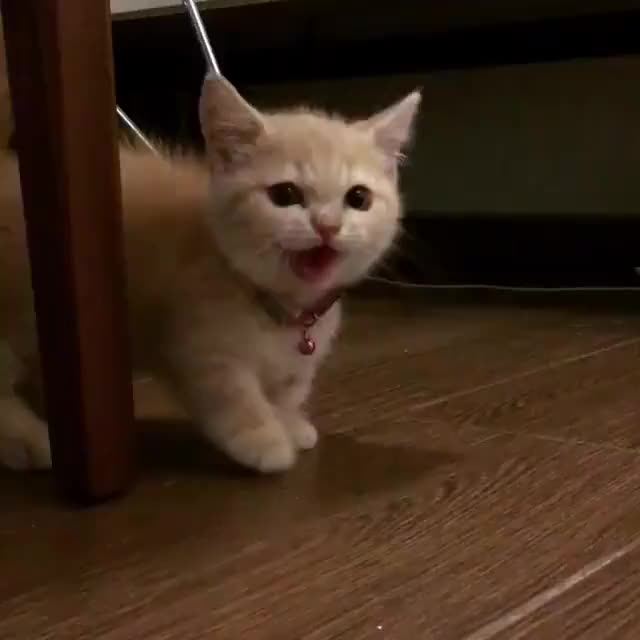

In [73]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('png/cat_1.jpg'))


In [74]:
! python sample.py --image='png/IMG_7283.JPG'

<start> a close up of a clock on a table <end>


In [75]:
display_jpeg(Image('png/IMG_7283.JPG'))


Output hidden; open in https://colab.research.google.com to view.

In [76]:
! python sample.py --image='png/IMG_7236.JPG'

<start> a woman sitting on a table with a bowl of food . <end>


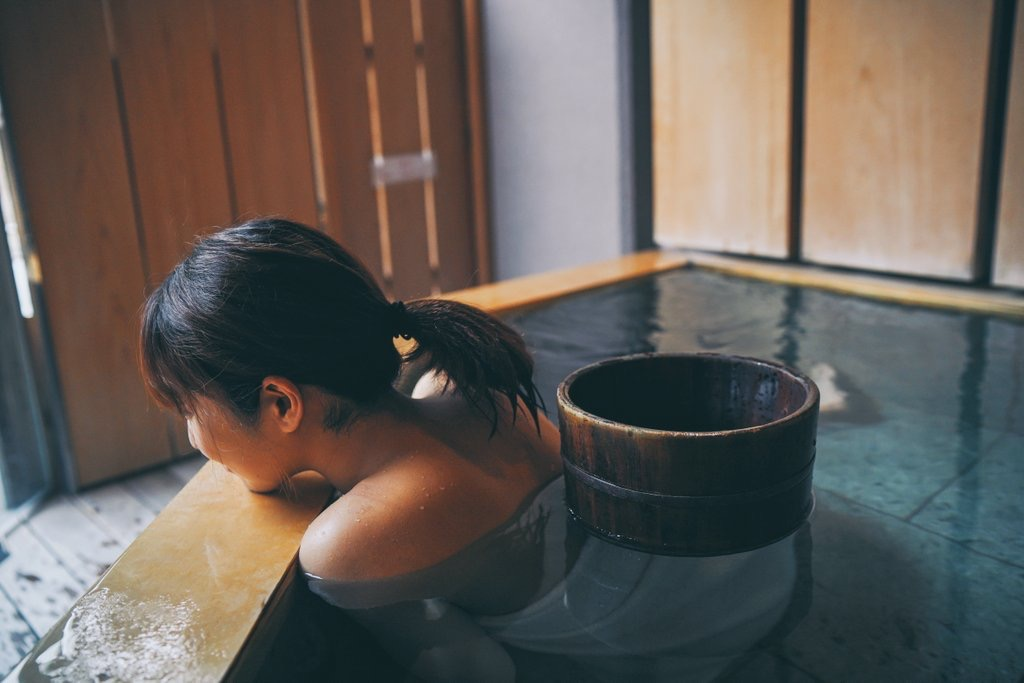

In [77]:
display_jpeg(Image('png/IMG_7236.JPG'))


In [78]:
! python sample.py --image='png/IMG_7141.JPG'

<start> a man holding a skateboard in front of a building . <end>


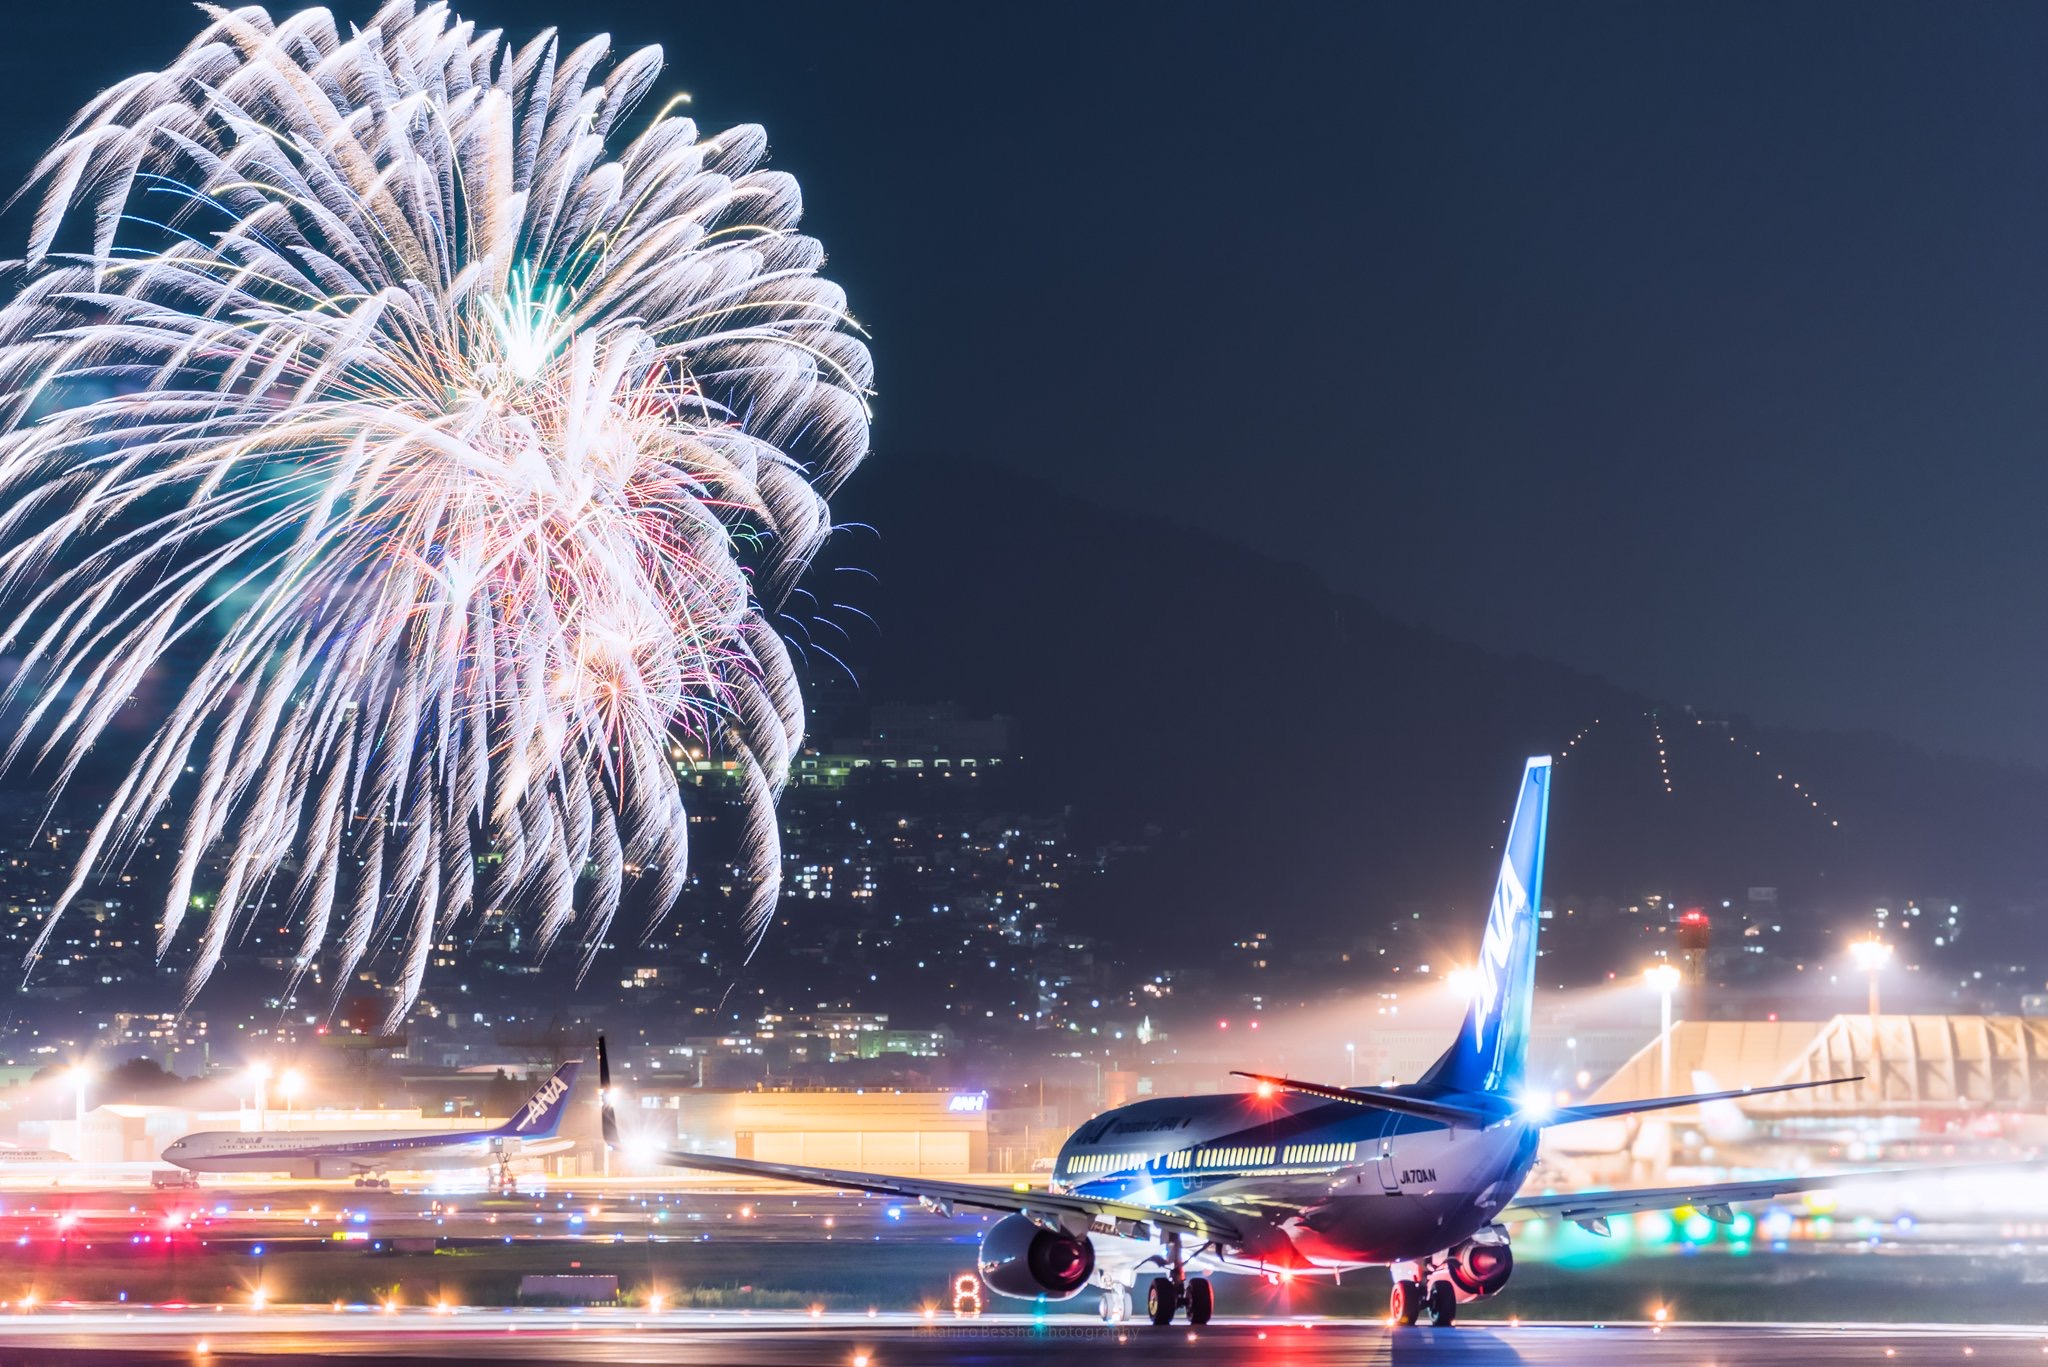

In [79]:
display_jpeg(Image('png/IMG_7141.JPG'))

## 【問題3】Kerasで動かしたい場合はどうするかを調査
>PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。
特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。



MMdnnとは、Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツール。中間表現を経由することで様々なフレームワーク間でのモデルデータの相互変換を実現する。
モデルの相互運用が可能なフレームワークは、Caffe, Keras, Tensorflow, CNTK, MXNet, PyTorch, CoreML。
テスト済みのモデルとしては、 VGG19、Inception v4、ResNet v2、SqueezeNet　あたりは全フレームワークで利用可能。
代表的なモデルに対応していれば、実用面ではあまり壁を感じないのではないかと感じる。。 多くの場合は代表的なモデルの転移学習だったり、もっとシンプルなモデルだったりするため、非常に有能である。

## 【問題4】（アドバンス課題）コードリーディングと書き換え
>モデル部分はmodel.pyに書かれていますが、Kerasではこのモデルがどのように記述できるかを考え、コーディングしてください。その際機械翻訳のサンプルコードが参考になります。

## 【問題5】（アドバンス課題）発展的調査
《他の言語の翻訳を行う場合は？》
>問題1の実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか考えてみましょう。

《機械翻訳の発展的手法にはどのようなものがある？》
>機械翻訳のための発展的手法にはどういったものがあるか調査してみましょう。

《文章から画像生成するには？》
>イメージキャプショニングとは逆に文章から画像を生成する手法もあります。どういったものがあるか調査してみましょう。

